The purpose of this notebook is to document different manipulations to metagenomes done to normalize comparison of different metagenomes to eachother.

First, let's get an idea of the differences between these two metagenomes...

Renaming them to be either "illumina" or "pyro"

Folder created: ```/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta```

in this folder (so far):


```
illumina_joined_gt150.fastq.gz  pyro_gt150.fastq.gz
```

These reflect metagenomes created in the processes documented in the jupyter notebook "illumina_vs_pyro".

So many options on what to do next... for example:
* chop up 454 library into read sizes similar to the joined illumina reads
* decrease the size of the illumina library so that the bp space is similar between illumina and pyrosequenced metagenomes

So next we'll take a peak at the differences between these two metagenomes.

We've got some information from the join set for the illumina library:

In [1]:
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/20160525/2079.6.1746.fastq_joinstats.txt ../data/i454comp/

2079.6.1746.fastq_joinstats.txt               100%  115     0.1KB/s   00:00    


In [2]:
!cat ../data/i454comp/2079.6.1746.fastq_joinstats.txt

metagenome	2079.6.1746.fastq
seqs_before_join	193290906
joined_pairs	71287501
total_bp	16752256254
mean_length	234


### *Illumina metagenome joined read size distribution:*

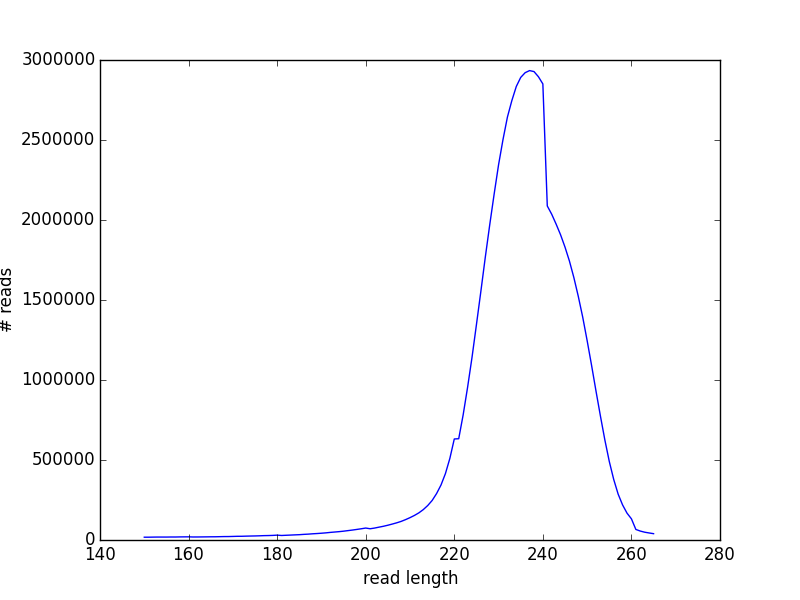

In [1]:
from IPython.display import Image

Image("../data/i454comp/2079.6.1746.fastq_joinstats.png")

Now to get the same set of information for the 454 read library... going to do this locally for better or worse.

In [1]:
import pandas as pd
import gzip
import os.path as op
from collections import defaultdict
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

from pysam import FastxFile

def readfx(fastx):
    fx = ""
    try:
        fx = FastxFile(fastx)
        for f in fx:
            yield f.name, f.sequence, f.quality
    finally:
        if fx:
            fx.close()
            
def plot_read_size(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    for name, seq, qual in readfx(fastq):
        readsizes[len(seq)] += 1
        readcount += 1
        bpcount += len(seq)
    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    hist['length']=hist.index
    hist['read_count']=hist[0]
    fig = plt.plot(hist['length'], hist['read_count'], color='b')
    plt.ylabel('# reads')
    plt.xlabel('read length')
    filename = op.dirname(fastq)+"_".join(op.basename(fastq).split(".")[:-1])+".png"
    name = "_".join(op.basename(fastq).split(".")[:-1])+".png"
    plt.title('%s: %s total reads' % (name, readcount))
    return plt, readcount, bpcount

In [10]:
pyroname = "../data/big_data/GZFH_454_gt150.fastq.gz"

The number of reads is: 554957 and the number of basepairs is: 206389798


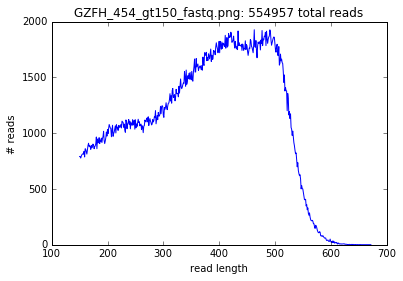

In [11]:
plt, readcount, bpcount = plot_read_size(pyroname)
print("The number of reads is:", readcount, "and the number of basepairs is:", bpcount)

In [13]:
meanbp = bpcount/readcount

In [14]:
import numpy as np

# from: http://stackoverflow.com/questions/5543651/computing-standard-deviation-in-a-stream
class OnlineVariance(object):
    """
    Welford's algorithm computes the sample variance incrementally.
    """

    def __init__(self, iterable=None, ddof=1):
        self.ddof, self.n, self.mean, self.M2 = ddof, 0, 0.0, 0.0
        if iterable is not None:
            for datum in iterable:
                self.include(datum)

    def include(self, datum):
        self.n += 1
        self.delta = datum - self.mean
        self.mean += self.delta / self.n
        self.M2 += self.delta * (datum - self.mean)
        self.variance = self.M2 / (self.n - self.ddof)

    @property
    def std(self):
        return np.sqrt(self.variance)
# example:   
N = 100
data = np.random.random(N)
ov = OnlineVariance(ddof=0)
for d in data:
    ov.include(d)
std = ov.std
print(std)

0.291297589008


In [15]:
def calc_size_sd(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    for name, seq, qual in readfx(fastq):
        size_var.include(len(seq))
    std=size_var.std
    return std

In [16]:
calc_size_sd(pyroname)

108.5062047133632

In [19]:
def calc_libe_stats(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    for name, seq, qual in readfx(fastq):
        size_var.include(len(seq))
        readsizes[len(seq)] += 1
        readcount += 1
        bpcount += len(seq)
    meanbp = bpcount/readcount
    readbp_std = size_var.std
    return pd.Series(data=[readcount, bpcount, meanbp, readbp_std], index=['read_count', 'bp_count', 'mean_read_len', 'read_len_std'])

In [20]:
ser = calc_libe_stats(pyroname)

In [37]:
ser = ser.rename('454_pyro')

In [38]:
illumina = pd.Series.from_csv("../data/i454comp/2079.6.1746.fastq_joinstats.txt", sep="\t")
illumina = illumina.rename(index={'joined_pairs': 'read_count', 'total_bp':'bp_count', 'mean_length':'mean_read_len'})
illumina = illumina.rename('illumina')

In [39]:
illumina

metagenome          2079.6.1746.fastq
seqs_before_join            193290906
read_count                   71287501
bp_count                  16752256254
mean_read_len                     234
Name: illumina, dtype: object

In [41]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [42]:
pd.concat([ser, illumina], axis=1, join='inner')

,454_pyro,illumina
read_count,554957,71287501
bp_count,206389798,16752256254
mean_read_len,372,234


In [70]:
def chop_read(name, seq, qual, length, minimum):
    pieces = round(len(seq)/length)
    div = round(len(seq)/pieces)
    newrecords= ""
    for i, n in enumerate(range(0, len(seq), div)):
        newname = "%s_%s" % (name, i+1)
        newseq = seq[n:n+div]
        newqual = qual[n:n+div]
        if len(newseq) > minimum:
            newrecords += "@%s\n%s\n+\n%s\n" % (newname, newseq, newqual)
    return newrecords

In [71]:
name = "NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA"
seq = "AAATTTTATTGAGGAGAATATCTAACCCATTACTCATAATCGCAGAAATTGATATTACTTCGGAAATGGATCCCTGATTCAATTTTCTTTCCAACTTTTTCAAGTTTTTTGCATCCAACAACTCTTTTTTATTCAGAACCAAAATCCTTGG"
qual = "<<AAAFFFFFFFFFFFAFFFFFF<.FFFAFFAFFFFFF.FFFFFFFFFFFFFFFAFFFFFFFFFFFFFFFFFFFFF.FAFFFFFFFFFFFFFFFFFFF<FFFFAFFFFFFFF7FFFFFFFFFFF)FFFFFFFFF<FAFF<FFF.FFFF7FF"

In [84]:
fqstring = chop_read(name, seq, qual, 15, 5)
print(fqstring)

@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_1
AAATTTTATTGAGGA
+
<<AAAFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_2
GAATATCTAACCCAT
+
FAFFFFFF<.FFFAF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_3
TACTCATAATCGCAG
+
FAFFFFFF.FFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_4
AAATTGATATTACTT
+
FFFFFFFFFAFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_5
CGGAAATGGATCCCT
+
FFFFFFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_6
GATTCAATTTTCTTT
+
F.FAFFFFFFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_7
CCAACTTTTTCAAGT
+
FFFFFFFF<FFFFAF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_8
TTTTTGCATCCAACA
+
FFFFFFF7FFFFFFF
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_9
ACTCTTTTTTATTCA
+
FFFF)FFFFFFFFF<
@NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_10
GAACCAAAATCCT

In [82]:
def read_fq_string(fq_string):
    lines = fq_string.split("\n")
    for n in range(0, len(lines)-1, 4):
        name = lines[n].replace("@","")
        seq = lines[n+1]
        qual = lines[n+3]
        yield name, seq, qual

In [85]:
for n, s, q in read_fq_string(fqstring):
    print("name:", n)
    print("sequence:", s)
    print("qual:", q)

name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_1
sequence: AAATTTTATTGAGGA
qual: <<AAAFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_2
sequence: GAATATCTAACCCAT
qual: FAFFFFFF<.FFFAF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_3
sequence: TACTCATAATCGCAG
qual: FAFFFFFF.FFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_4
sequence: AAATTGATATTACTT
qual: FFFFFFFFFAFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_5
sequence: CGGAAATGGATCCCT
qual: FFFFFFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_6
sequence: GATTCAATTTTCTTT
qual: F.FAFFFFFFFFFFF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_7
sequence: CCAACTTTTTCAAGT
qual: FFFFFFFF<FFFFAF
name: NS500409:16:H184TBGXX:1:11101:17876:1098 1:N:0:AGGCAGAA+AGAGGATA_8
sequence: TTTTTGCATCCAACA
qual: FFFFFFF7FFFFFFF
name: NS500409:16:H184TBGXX:1:11

In [ ]:
def chop_reads(fastq, out_file, length, minlength, cores=10):
    
    if not out_file.endswith('.gz'):
        out_file = out_file + '.gz'
    
    if file_exists(out_file):
        print("output file exists, chop reads will not repeat itself.")
        return out_file
    
    p = multiprocessing.Pool(cores)
    
    original_count = 0
    readcount = 0
    bpcount = 0
    size_var = OnlineVariance(ddof=0)
    
    with file_transaction(out_file) as tx_outfile:
        with open(tx_outfile, "w") as txoh:
            for result in multiprocess(chop_read, readfx(fastq), 230, 150, pool=p):
                original_count += 1
                print(result, file=txoh)
                
                for name, seq, qual in read_fq_string(result):
                    readcount += 1
                    bpcount += len(seq)
                    size_var.include(len(seq))
    
    meanbp = bpcount/readcount
    readbp_std = size_var.std
    out_file = pigz_file(out_file, cores)
    
    outdata = pd.Series(data=[original_count, readcount, bpcount, meanbp, readbp_std], index=['original_count', 'read_count', 'bp_count', 'mean_read_len', 'read_len_std'])
    print(outdata)
    outdata.to_csv(outfile.replace("fastq.gz",".chop_data"), sep="\t")
    return out_file

Created script to chop reads based on above scratch, tested with 454 library.

In [91]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_230.fastq.gz ../data/big_data/

pyro_chopped_230.fastq.gz                     100%  158MB  12.2MB/s   00:13    


### Read size distribution after chop_reads centered around 230bp:

(<module 'matplotlib.pyplot' from '//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 897344,
 206270423)

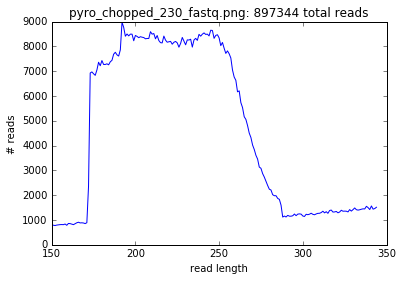

In [92]:
plot_read_size('../data/big_data/pyro_chopped_230.fastq.gz')

Alright, that distribution's OK, but not pretty... and the distribution of read lengths for illumina data, while similar, is much more narrow.  Going to mess with the chop script to see if I can get a more narrow distribution.

```
fq=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_gt150.fastq.gz
outfile=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped2_230.fastq.gz

python ~/scripts/chop_reads.py chop --length 230 --fastq $fq --minlength 150 --outfile $outfile --cores 20
```

In [31]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped2_230.fastq.gz ../data/big_data/

pyro_chopped2_230.fastq.gz                    100%  158MB  14.4MB/s   00:11    


In [3]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped3_230.fastq.gz ../data/big_data/

pyro_chopped3_230.fastq.gz                    100%  107MB  13.4MB/s   00:08    


In [7]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped5_230.fastq.gz ../data/big_data/

pyro_chopped5_230.fastq.gz                    100%  141MB  15.6MB/s   00:09    


Setting default splitting length to 230:

(<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>,
 837866,
 185620365)

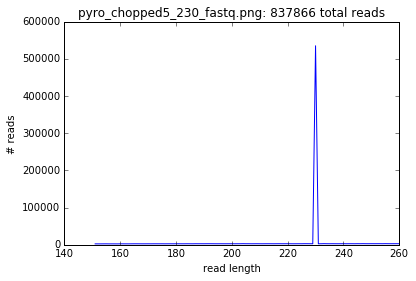

In [8]:
plot_read_size("../data/big_data/pyro_chopped5_230.fastq.gz")

```
outfile=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped5_230.fastq.gz

python ~/scripts/chop_reads.py chop --length 230 --fastq $fq --minlength 150 --outfile $outfile --cores 20
```

Now sampling splitting location from normal distribution:
```
outfile=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_norm_230.fastq.gz

python ~/scripts/chop_reads.py chop --length 240 --fastq $fq --minlength 150 --outfile $outfile --cores 20
```

In [32]:
!scp charlie:/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_norm_230.fastq.gz ../data/big_data/

pyro_chopped_norm_230.fastq.gz                100%  141MB  11.7MB/s   00:12    


(<module 'matplotlib.pyplot' from '//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>,
 820644,
 185735336)

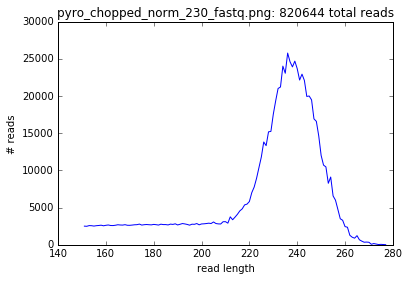

In [33]:
plot_read_size("../data/big_data/pyro_chopped_norm_230.fastq.gz")

OK!  Now let's do some recruiting!

```
mg=Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_230.fastq.gz
log=0506_ncov.log
outdir=fragdev/20160604

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: firstlist.txt

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: thenthese.txt


mg=Test_FragRecruitment/Sakinaw/manmeta/pyro_chopped_norm_230.fastq.gz
log
log=0606ncov.log
outdir=fragdev/pyro_norm
parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: allsakinawsags.txt

```

```
outdir=/mnt/stepanauskas_nfs/julia/fragdev/20160604/
refdir=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/Hallam_SAGs_AAA255/Masked_genomes_AAA255/

python ~/scripts/mp_recruit.py jrmr --fq1 $mg --outdir $outdir \
--refdir $refdir &> 0604_jrmr.log
```

### and to compare, I'm going to subsample the illumina library to have the same number of reads as the chopped up pyro-sequenced library

I've taken the "run_seqtk_sample" function from sgcg.apps.run_seqtk_sample, changed it to work with a single fastq file and made it executable in the script ```sample.py``` in the directory ```sag_mg_recruit```.  

On charlie, running the command:

```
fastq=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/illumina_joined_gt150.fastq.gz
outfile=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/illumina_joined_gt150_sub1.fastq.gz
python ~/scripts/sample.py sample --n 820644 --fastq $fastq --outfile $outfile
```

And recruit to the SAGs:

```
mg=/mnt/stepanauskas_nfs/julia/Test_FragRecruitment/Sakinaw/manmeta/illumina_joined_gt150_sub1.fastq.gz

outdir=/mnt/stepanauskas_nfs/julia/fragdev/illumina_sub1/

log=20160606_rcovlog.txt

parallel --retries 1 --bar --load 70% --joblog $log --jobs 3 python ~/scripts/rcov2.py \
print_cov --fastq $mg --reference {1} --outdir $outdir :::: allsakinawsags.txt
```

In [1]:
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/pyro_norm/*genomecoverage ../data/allsags/pyrochoppednorm/
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/pyro_norm/*aln_count ../data/allsags/pyrochoppednorm/

pyro_chopped_norm_230_fastq_vs_AAA255A6_96912 100%   52MB  10.4MB/s   00:05    
pyro_chopped_norm_230_fastq_vs_AAA255B16_9768 100%   46MB  15.4MB/s   00:03    
pyro_chopped_norm_230_fastq_vs_AAA255C20_9806 100%   59MB   9.8MB/s   00:06    
pyro_chopped_norm_230_fastq_vs_AAA255E10_9556 100% 1090KB   1.1MB/s   00:00    
pyro_chopped_norm_230_fastq_vs_AAA255E4_97381 100% 4208KB   4.1MB/s   00:01    
pyro_chopped_norm_230_fastq_vs_AAA255E5_97489 100%   31MB   7.7MB/s   00:04    
pyro_chopped_norm_230_fastq_vs_AAA255F10_9665 100%  500KB 499.9KB/s   00:00    
pyro_chopped_norm_230_fastq_vs_AAA255F6_96485 100%   15MB  14.5MB/s   00:01    
pyro_chopped_norm_230_fastq_vs_AAA255F9_97162 100%   37MB  12.3MB/s   00:03    
pyro_chopped_norm_230_fastq_vs_AAA255G5_97045 100%   36MB  11.8MB/s   00:03    
pyro_chopped_norm_230_fastq_vs_AAA255J7_97950 100% 2233KB   2.2MB/s   00:00    
pyro_chopped_norm_230_fastq_vs_AAA255K14_9677 100%   10MB  10.4MB/s   00:01    
pyro_chopped_norm_230_fastq_vs_AAA255L20

In [2]:
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/illumina_sub1/*.genomecoverage ../data/allsags/illuminasub/
!scp charlie:/mnt/stepanauskas_nfs/julia/fragdev/illumina_sub1/*.aln_count ../data/allsags/illuminasub/

illumina_joined_gt150_sub1_fastq_vs_AAA255A6_ 100%   55MB  11.0MB/s   00:05    
illumina_joined_gt150_sub1_fastq_vs_AAA255B16 100%   47MB  11.7MB/s   00:04    
illumina_joined_gt150_sub1_fastq_vs_AAA255C20 100%   60MB  12.0MB/s   00:05    
illumina_joined_gt150_sub1_fastq_vs_AAA255E10 100% 1400KB   1.4MB/s   00:00    
illumina_joined_gt150_sub1_fastq_vs_AAA255E4_ 100% 5098KB   5.0MB/s   00:00    
illumina_joined_gt150_sub1_fastq_vs_AAA255E5_ 100%   33MB  11.0MB/s   00:03    
illumina_joined_gt150_sub1_fastq_vs_AAA255F10 100%  749KB 748.6KB/s   00:00    
illumina_joined_gt150_sub1_fastq_vs_AAA255F6_ 100%   16MB  15.9MB/s   00:01    
illumina_joined_gt150_sub1_fastq_vs_AAA255F9_ 100%   39MB   9.8MB/s   00:04    
illumina_joined_gt150_sub1_fastq_vs_AAA255G5_ 100%   42MB  14.1MB/s   00:03    
illumina_joined_gt150_sub1_fastq_vs_AAA255J7_ 100% 2126KB   2.1MB/s   00:01    
illumina_joined_gt150_sub1_fastq_vs_AAA255K14 100%   11MB  11.0MB/s   00:01    
illumina_joined_gt150_sub1_fastq_vs_AAA2

In [3]:
# %load ../sag_mg_recruit/workup_functions.py
import pandas as pd
import gzip
import os.path as op
from collections import defaultdict
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

#from pysam import FastxFile


def readfx(fastx):
    fx = ""
    try:
        fx = FastxFile(fastx)
        for f in fx:
            yield f.name, f.sequence, f.quality
    finally:
        if fx:
            fx.close()


gzopen = lambda x: gzip.open(x) if x.endswith(".gz") else open(x)


def plot_read_size(fastq):
    readsizes = defaultdict(lambda: 0)
    readcount = 0
    for name, seq, qual in readfx(fastq):
        readsizes[len(seq)] += 1
        readcount += 1
    hist = pd.DataFrame.from_dict(readsizes, orient='index')
    hist['length']=hist.index
    hist['read_count']=hist[0]
    fig = plt.plot(hist['length'], hist['read_count'], color='b')
    plt.ylabel('# reads')
    plt.xlabel('read length')
    filename = op.dirname(fastq)+"_".join(op.basename(fastq).split(".")[:-1])+".png"
    name = "_".join(op.basename(fastq).split(".")[:-1])+".png"
    plt.title('%s: %s total reads' % (name, readcount))
    return plt, readcount


def get_recruit_info(gcov):
    countfile = gcov.replace("genomecoverage", "aln_count")
    with open(countfile) as infile:
        recruit_count = infile.read().split()[1].strip()
        
    metagenome = op.basename(gcov).split("_vs_")[0].split("_")[0]
    coverage = pd.read_csv(gcov, sep="\t", header=None)
    mean_per_contig = coverage.groupby([0])[2].mean() #.to_dict()
    sum_per_contig = coverage.groupby([0])[2].sum() #.to_dict()
    contig_size = coverage.groupby([0])[1].max()+1
    mean_sag_coverage = mean_per_contig.mean()
    totalbp = contig_size.sum()
    uncovered_bp = sum(coverage[2]==0)
    pct_covered = (totalbp - uncovered_bp)/totalbp * 100
    total_scaffold = len(sum_per_contig)
    uncovered_contig = sum(sum_per_contig==0)
    pct_scaffolds_covered = (total_scaffold - uncovered_contig)/total_scaffold *100
    sag = "_".join(op.basename(gcov).split("_vs_")[1].strip(".genomecoverage").split("_")[:-1])
    cols = ['method','sag','metagenome','Percent_scaffolds_with_any_coverage', 'Percent_of_reference_bases_covered', 'Average_coverage', 'unambiguous']
    data = ['bwa', sag, metagenome, 
           pct_scaffolds_covered,
           pct_covered, 
           mean_sag_coverage,
           recruit_count]
    df = pd.DataFrame(data, index=cols).transpose()
    return df

def genome_cov_table(gcov_list):
    cols = ['sag','metagenome','Percent_scaffolds_with_any_coverage', 'Percent_of_reference_bases_covered', 'Average_coverage', 'unambiguous']
    big = pd.DataFrame(columns=cols)
    for g in gcov_list:
        new=get_recruit_info(g)
        big = pd.concat([big, new])
    return big


In [4]:
gcov1 = glob.glob("../data/allsags/pyrochoppednorm/*.genomecoverage")
len(gcov1)
gcov2 = glob.glob("../data/allsags/illuminasub/*.genomecoverage")
both = gcov1+gcov2

In [5]:
stats = genome_cov_table(both)

In [6]:
together = stats

In [7]:
together

,Average_coverage,Percent_of_reference_bases_covered,Percent_scaffolds_with_any_coverage,metagenome,method,sag,unambiguous
0,2.52312,100,100,pyro,bwa,AAA255A6_96912,13602
0,5.29082,100,100,pyro,bwa,AAA255B16_97682,25387
0,5.05685,100,100,pyro,bwa,AAA255C20_98068,31265
0,1.3936,100,100,pyro,bwa,AAA255E10_95567,185
0,2.09656,100,100,pyro,bwa,AAA255E4_97381,950
0,2.52232,100,100,pyro,bwa,AAA255E5_97489,8188
0,1.10914,100,100,pyro,bwa,AAA255F10_96652,59
0,2.41823,100,100,pyro,bwa,AAA255F6_96485,3696
0,2.52436,100,100,pyro,bwa,AAA255F9_97162,9537
0,2.02288,100,100,pyro,bwa,AAA255G5_97045,8306


In [8]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['ggplot2', 'dplyr', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [9]:
%%R -i together
Reads_Used <- 897344
together <- mutate(together, vars = paste(metagenome, method, sep="_"))
together <- mutate(together, frac_mg_reads = as.numeric(as.character(unambiguous))/Reads_Used)

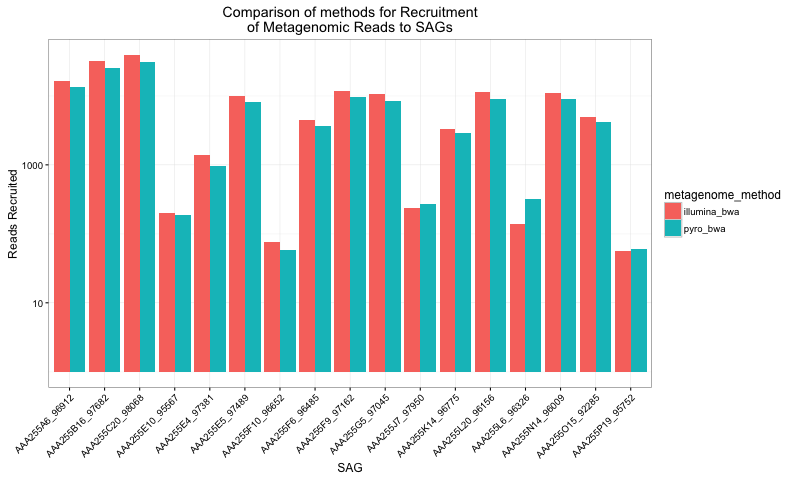

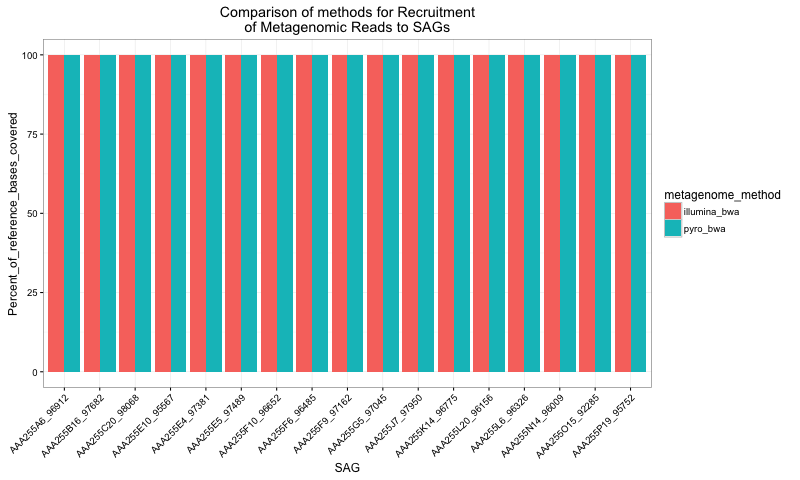

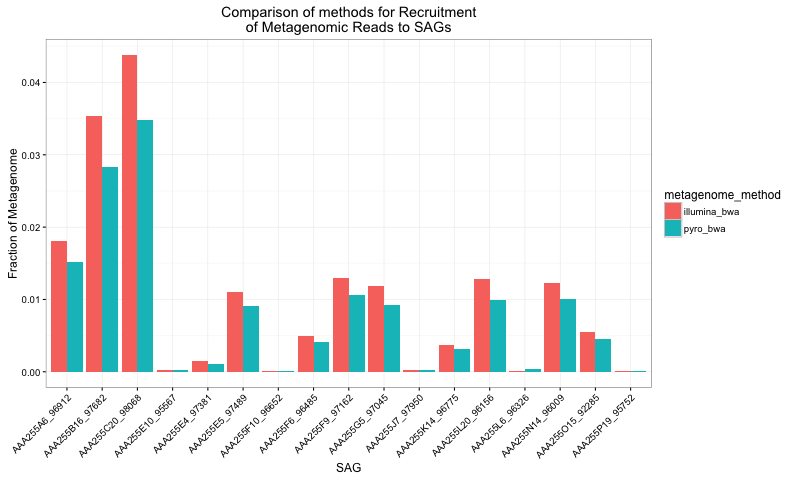

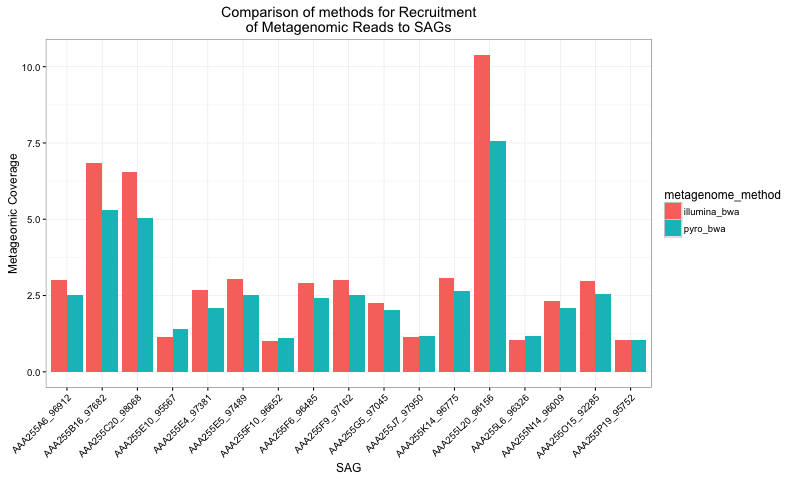

In [14]:
%%R -w 800
together %>% ggplot(aes(sag, as.numeric(as.character(unambiguous)))) + scale_y_log10() + theme_bw() -> p
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Reads Recruited", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

together %>% ggplot(aes(sag, as.numeric(as.character(Percent_of_reference_bases_covered)))) + theme_bw() -> p 
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Percent_of_reference_bases_covered", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

together %>% ggplot(aes(sag, as.numeric(as.character(frac_mg_reads)))) + theme_bw() -> p 
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Fraction of Metagenome", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

together %>% ggplot(aes(sag, as.numeric(as.character(Average_coverage)))) + theme_bw() -> p 
p<- p+ geom_bar(aes(fill=vars), position="dodge", stat='identity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))
p <- p + labs(fill="metagenome_method", x="SAG", y="Metageomic Coverage", title="Comparison of methods for Recruitment\nof Metagenomic Reads to SAGs")
plot(p)

In [57]:
%%R
# from: https://susanejohnston.wordpress.com/2012/08/09/a-quick-and-easy-function-to-plot-lm-results-in-r/
ggplotRegression <- function (fit) {

require(ggplot2)

ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1])) + 
  geom_point(size=3) +
  stat_smooth(method = "lm", col = "grey") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),"\n",
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 5)))
}

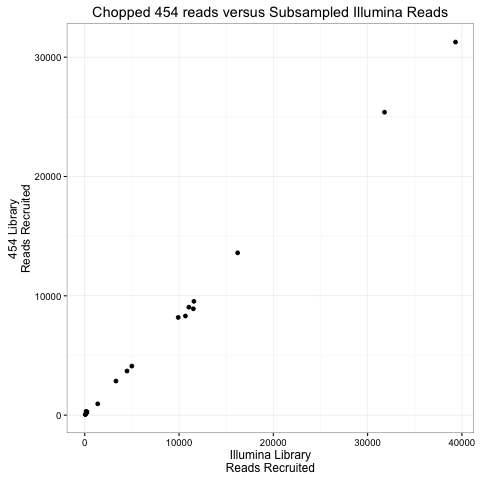

In [59]:
%%R
illumina <- together %>% filter(metagenome=="illumina") %>% .[,c('sag','unambiguous')]
colnames(illumina)[2] <- "illumina_reads_recruited"
pyro <- together %>% filter(metagenome=="pyro") %>% .[,c('sag','unambiguous')]
colnames(pyro)[2] <- "pyro_reads_recruited"

reads_by_libe <- merge(illumina, pyro, by="sag")

p <- ggplot(reads_by_libe, aes(as.numeric(as.character(illumina_reads_recruited)), as.numeric(as.character(pyro_reads_recruited)))) 
p <- p + geom_point() + theme_bw() +labs(x="Illumina Library\nReads Recruited", y="454 Library\nReads Recruited", title = "Chopped 454 reads versus Subsampled Illumina Reads")
plot(p)

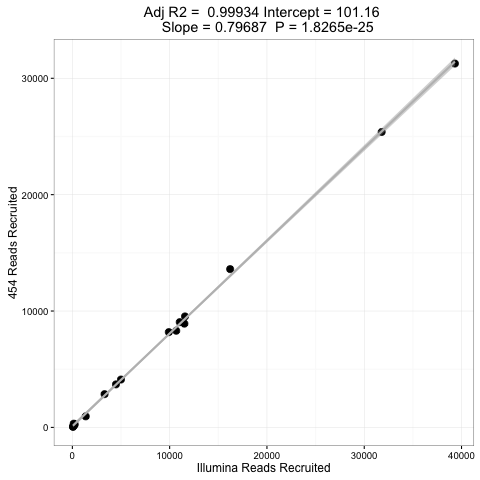

In [60]:
%%R
reads_by_libe[,c(2,3)] <- lapply(reads_by_libe[c(2,3)], function(x) as.numeric(as.character(x)))

fit1 <- lm(pyro_reads_recruited ~ illumina_reads_recruited, data = reads_by_libe)
ggplotRegression(fit1)+theme_bw()+labs(x="Illumina Reads Recruited", y="454 Reads Recruited")

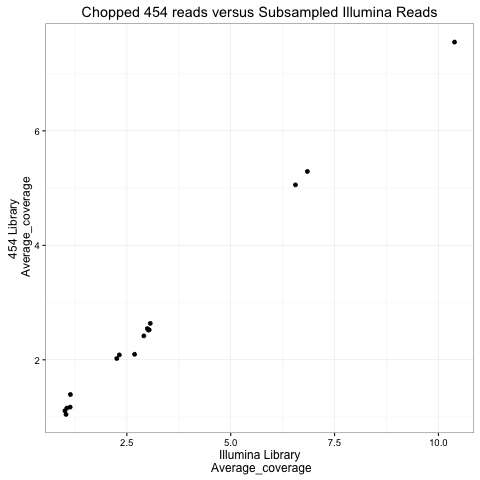

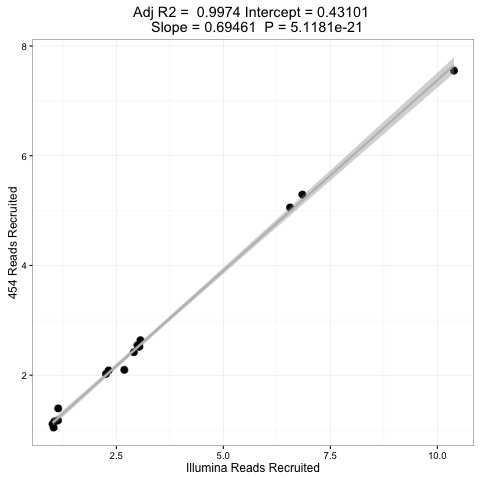

In [63]:
%%R
stat <- 'Average_coverage'
illumina <- together %>% filter(metagenome=="illumina") %>% .[,c('sag',stat)]
colnames(illumina)[2] <- paste("illumina_", stat, sep="")
pyro <- together %>% filter(metagenome=="pyro") %>% .[,c('sag',stat)]
colnames(pyro)[2] <- paste("pyro_", stat, sep="")

merged <- merge(illumina, pyro, by="sag")

merged[,c(2,3)] <- lapply(merged[c(2,3)], function(x) as.numeric(as.character(x)))

p <- ggplot(merged, aes(merged[,2], merged[,3])) 
p <- p + geom_point() + theme_bw() +labs(x=paste("Illumina Library\n", stat), y=paste("454 Library\n", stat), title = "Chopped 454 reads versus Subsampled Illumina Reads")
plot(p)
    
fit1 <- lm(merged[,3] ~ merged[,2])
ggplotRegression(fit1)+theme_bw()+labs(x="Illumina Reads Recruited", y="454 Reads Recruited")

In [ ]:
%%R
